# Climpyrical National Building Code
## Analysis of Gradient Boosting Regression Using 15 Spatial Orthogonal Basis Functions
Nic Annau, Pacific Climate Impacts Consortium

## Load Climpyrical and Other Dependencies

In [6]:
!pip install ../../.
from climpyrical.mask import *
from climpyrical.gridding import *
from climpyrical.datacube import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import pickle

%load_ext autoreload
%autoreload 2

Processing /home/nannau/climpyrical
  Running setup.py bdist_wheel for climpyrical ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-32amqvvq/wheels/13/3c/a6/00fb5ab74f9b879446c17ea82ae9c2b5c682e8493125b75123
Successfully built climpyrical
  Found existing installation: climpyrical 0.1.dev0
    Uninstalling climpyrical-0.1.dev0:
      Successfully uninstalled climpyrical-0.1.dev0
You are using pip version 18.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Ensemble from File

In [7]:
PATH = '../../climpyrical/tests/data/snw_test_ensemble.nc'
dv = 'Rain-RL50'
ds = read_data(PATH, dv)

dx, dy = np.diff(ds.rlon.values).mean()/3, np.diff(ds.rlat.values).mean()/3
inrlon = np.linspace(ds.rlon.min()-dx, ds.rlon.max()+dx, ds.rlon.shape[0]*3)
inrlat = np.linspace(ds.rlat.min()-dy, ds.rlat.max()+dy, ds.rlat.shape[0]*3)
new_ens = np.ones((inrlat.size, inrlon.size))

new_ds = np.repeat(np.repeat(ds[dv].values, 3, axis=1), 3, axis=2)

ids = xr.Dataset({dv: (['level', 'y', 'x'], new_ds)}, 
                 coords={'rlon':  ('x', inrlon), 
                         'rlat': ('y', inrlat), 
                         'level': ('level', range(35))})
ds = ids

## Load Shapefile and Generate Mask

In [8]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
can_index = world[world.name == "Canada"].index
can_geom = world.loc[can_index, 'geometry']

canada = rotate_shapefile(can_geom)

mask = gen_raster_mask_from_vector(ds.rlon.values, ds.rlat.values, canada)

In [9]:
ds.rlon

<xarray.DataArray 'rlon' (x: 465)>
array([-34.026672, -33.880005, -33.733338, ...,  33.733338,  33.880005,
        34.026672])
Coordinates:
    rlon     (x) float64 -34.03 -33.88 -33.73 -33.59 ... 33.59 33.73 33.88 34.03
Dimensions without coordinates: x

## Take Anomally of Design Value Ensembles

In [40]:
ens_mean = ds[dv].values.mean(axis=0)
ens_mean.shape

(390, 465)

## Apply any additional masking
If the model has any NaN values left over that the mask did not catch, find them, and add them to the mask using `logical_and`. Reshape arrays and mask to all work with the same mask. 

In [41]:
# Create a mask of extra NaN values that is flattened
flat_mask_with_extra_nan = np.logical_and(~np.isnan(ens_mean.flatten()), mask.flatten())

# Put back into the spatial shape
final_mask = flat_mask_with_extra_nan.reshape(ens_mean.shape)

# create two grids of rlon and rlat to use new mask with
rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

# check that the shapes of all of the arrays after masking are consistent
assert rlat[final_mask].shape == rlon[final_mask].shape and ens_mean[final_mask].shape == rlat[final_mask].shape

## Interpolated to 3x3 Grids

In [42]:
ds[dv].values.shape, final_mask

((35, 390, 465), array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]))

# Load the station data from file
Add new columns of converted longitude and latitude into rotated pole coordinate

In [294]:
from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from scipy import stats

frac = 0.01

df = pd.read_csv('../../climpyrical/tests/data/stations.csv', index_col=None)

df['rlon'], df['rlat'] = transform_coords(df['lon'].values, df['lat'].values)
df = df[df['RL50 (kPa)'] != 0.0]
rlon_ens, rlat_ens = flatten_coords(ds.rlon.values, ds.rlat.values, ds)

dist_to_closest_station = pairwise_distances_argmin_min(
            np.array(list(zip(rlon_ens, rlat_ens))),
            np.array(list(zip(df.rlon, df.rlat))),
            metric='euclidean'
        )[1]

df_non_stations = pd.DataFrame({
                    'rlon': rlon[final_mask], 
                    'rlat': rlat[final_mask], 
                    'mean': ens_mean[final_mask],
                    'distance_weights': dist_to_closest_station[final_mask.flatten()]**2.5
})

img_dist_arr = np.reshape(dist_to_closest_station, ens_mean.shape)
img_dist_arr[~final_mask] = np.nan

df['label'] = 'stations'

df_non_stations_weight = df_non_stations.sample(frac=frac, weights='distance_weights')
df_to_add = pd.DataFrame({
                'rlon': df_non_stations_weight.rlon, 
                'rlat': df_non_stations_weight.rlat, 
                'RL50 (kPa)': df_non_stations_weight['mean'],
                'label': 'model'})



######################################################################################
radius_size = 300/((50/3)/np.diff(ds.rlon.values).mean())

from shapely.geometry import Point, Polygon
import random
from sklearn.neighbors import KDTree
ndfpseudo = ndf.copy()
tree = KDTree(np.array(list(zip(ndf.rlon, ndf.rlat))))
max_count = tree.query_radius(np.array(list(zip(ndfpseudo.rlon, ndfpseudo.rlat))),r=radius_size, count_only=True).max()
dfarr = ndfpseudo[['rlon', 'rlat', 'label']]

entire_field = int((max_count/(np.pi*radius_size**2))*(ds.rlon.values.max()-ds.rlon.values.min())*(ds.rlat.values.max()-ds.rlat.values.min()))
xn = np.random.uniform(ds.rlon.values.max(), ds.rlon.values.min(), entire_field)
yn = np.random.uniform(ds.rlat.values.max(), ds.rlat.values.min(), entire_field)
ndf_full = pd.concat([dfarr, pd.DataFrame({'rlon':xn, 'rlat':yn, 'label': 'pseudo'})])

ndf_full_arr = ndf_full.values

# def recursion(ndf_full_arr):
arlon,arlat = ndf_full_arr[:,0], ndf_full_arr[:,1]
tree = KDTree(np.array(list(zip(arlon, arlat))))
i=0
to_keep = np.ones(ndf_full_arr.shape[0]) == 1

def get_sum(ndf_full_arr):
    arlon, arlat = ndf_full_arr[:,0], ndf_full_arr[:,1]
    return KDTree(np.array(list(zip(arlon, arlat))))

for irlon, irlat, ilabel in ndf_full_arr:
    temp_arr = ndf_full_arr[np.array(to_keep)]
    tree = get_sum(temp_arr)
    sums = tree.query_radius(np.array([irlon, irlat]).reshape(1, -1),r=radius_size, count_only=True)

    if sums >= max_count and ilabel == 'pseudo':
        to_keep[i] = False
    else:
        to_keep[i] = True
    i+=1
    
dfarr = ndf_full_arr[np.array(to_keep)]
    
df_to_add = pd.DataFrame(
                    {
                        'rlon': dfarr[:, 0],
                        'rlat': dfarr[:, 1],
                        'label': dfarr[:, 2],
                    }
)
df_to_add = df_to_add[df_to_add.apply(lambda x: (canada.contains(Point(x.rlon, x.rlat)).values[0]), axis=1)]
df_to_add = df_to_add[df_to_add.label == 'pseudo']

df = pd.concat([df, df_to_add], sort=False)

rlon_i, rlat_i = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df.rlon.values, df.rlat.values)

# Add nearest rlon and rlat locations in grid to stations
df['rlon_nearest'], df['rlat_nearest'] = ds.rlon.values[rlon_i], ds.rlat.values[rlat_i]
df['rlon_nearest_index'], df['rlat_nearest_index'] = rlon_i, rlat_i

# Zip together a tuple of grid indices
df['nearest_grid'] = list(zip(rlon_i, rlat_i))
df['count'] = df['nearest_grid']

# Group together stations falling in same grid cell and take mean
station_dv = 'RL50 (kPa)'
ndf = df.groupby(['nearest_grid'], as_index=False).agg({
                                station_dv: 'mean',
                                'lat':'min',
                                'lon':'min',
                                'rlat':'min',
                                'rlon':'min',
                                'rlat_nearest':'min',
                                'rlon_nearest':'min',
                                'rlon_nearest_index':'mean',
                                'rlat_nearest_index':'mean',
                                'label': 'min',
                                'count':'count'
                            })

# Remove stations with zero rainfall as advised
ndf = ndf[ndf['RL50 (kPa)'] != 0.0]
# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values

ndf['mean_values_at_real_stations'] = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, ens_mean, final_mask, ds)

# Get the indices for each grid axis that are matched and grouped
rlon_i_agg, rlat_i_agg = ndf.rlon_nearest_index.values, ndf.rlat_nearest_index.values
rlon_i_agg_p, rlat_i_agg_p = ndf[ndf.label=='stations'].rlon_nearest_index.values, ndf[ndf.label=='stations'].rlat_nearest_index.values

mean_values_at_real_stations = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, ens_mean, final_mask, ds)
mean_values_at_real_stations_p = find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, ens_mean, final_mask, ds)

# mean_values_at_real_stations = m*mean_values_at_real_stations
bases = [find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg, rlat_i_agg, ds[dv].values[i, :, :], final_mask, ds) for i in range(35)]
basesp = [find_nearest_index_value(ds.rlon.values, ds.rlat.values, rlon_i_agg_p, rlat_i_agg_p, ds[dv].values[i, :, :], final_mask, ds) for i in range(35)] 

values = np.stack(bases)
values = np.concatenate((values, ndf.rlon_nearest.values.reshape(1, -1)), axis=0)
values = np.concatenate((values, ndf.rlat_nearest.values.reshape(1, -1)), axis=0)

valuesp = np.stack(basesp)
valuesp = np.concatenate((valuesp, ndf[ndf.label=='stations'].rlon_nearest.values.reshape(1, -1)), axis=0)
valuesp = np.concatenate((valuesp, ndf[ndf.label=='stations'].rlat_nearest.values.reshape(1, -1)), axis=0)

X, Y = values.T, (ndf['RL50 (kPa)'].values)/ndf['mean_values_at_real_stations'].values
Xp, Yp = valuesp.T, ndf[ndf.label=='stations']['RL50 (kPa)']
# X, Y = shuffle(X, Y, random_state=0)

model = KNeighborsRegressor(n_neighbors=5, weights='distance')
model.fit(X, Y)

modelp = KNeighborsRegressor(n_neighbors=5, weights='distance')
modelp.fit(Xp, Yp)

ndf['predict'] = (model.predict(X))#, random_state=0)
stations = ndf[ndf.label == 'stations']

rmse = np.sqrt(mean_squared_error(
    ndf[ndf.label == 'stations']['RL50 (kPa)'], 
    stations['predict']
)
)

rmse_mean_sample = np.sqrt(mean_squared_error(
    ndf['RL50 (kPa)'], 
    ndf['predict']
)
)

sx, sy = ndf['rlon_nearest_index'].values, ndf['rlat_nearest_index'].values

mean_values_at_real_stations = find_nearest_index_value(ds.rlon.values, ds.rlat.values, sx, sy, ens_mean, final_mask, ds)

rmse_mean_and_stations = np.sqrt(mean_squared_error(
#         ndf[ndf.label == 'stations']['RL50 (kPa)'], 
    ndf['RL50 (kPa)'],   
    mean_values_at_real_stations
)
)

dc = ds[dv].values[0, ...].flatten().copy()
d_gridx = np.moveaxis(ds[dv].values, 0, -1)#[..., important_features]
d_gridx = np.dstack((d_gridx, rlon))
d_gridx = np.dstack((d_gridx, rlat))
dc[final_mask.flatten()] = (model.predict((d_gridx[final_mask])))*ens_mean[final_mask]

dcp= dc.copy()
dcp[final_mask.flatten()] = (modelp.predict((d_gridx[final_mask])))

dc[~final_mask.flatten()] = np.nan
dcp[~final_mask.flatten()] = np.nan
# final_pseudo = dc.reshape(d_gridx[..., 0].shape)
final.append(dc.reshape(d_gridx[..., 0].shape))
# final = dc.reshape(d_gridx[..., 0].shape)
finalp = dcp.reshape(d_gridx[..., 0].shape)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [165]:
final = np.mean(np.array(final), axis=0)

In [174]:
ens_mean = ds[dv].values.mean(axis=0)

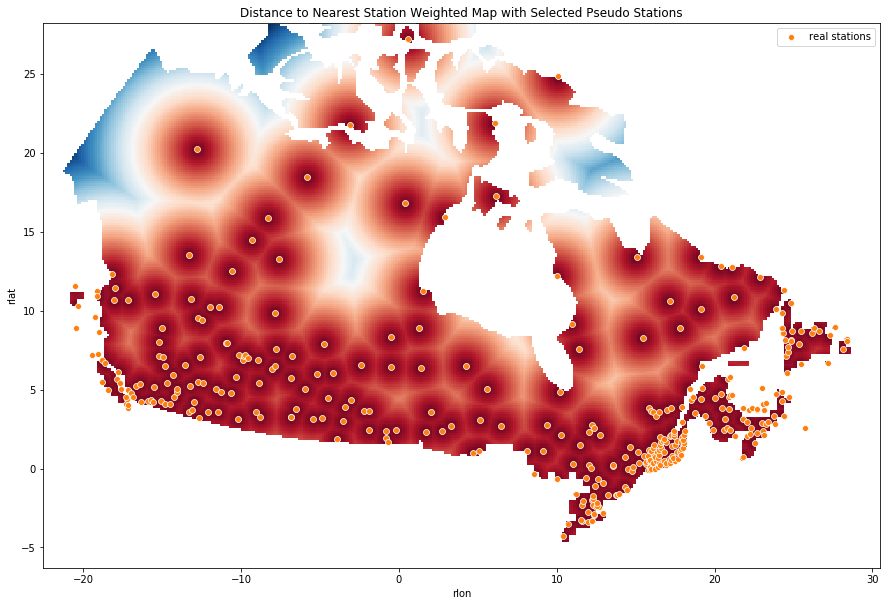

In [175]:
plt.figure(figsize=(15, 15))
sns.scatterplot('rlon', 'rlat',  marker='o', data=ndf[ndf.label=='model'], label='pseudo stations')
sns.scatterplot('rlon', 'rlat',  marker='o', data=ndf[ndf.label=='stations'], label='real stations')

plt.imshow(
    img_dist_arr, 
    cmap='RdBu', 
    origin='lower', 
    extent=[
            ds.rlon.values.min(),
            ds.rlon.values.max(),
            ds.rlat.values.min(),
            ds.rlat.values.max()
        ],
    label='distance weighting'
)
plt.ylim(df.rlat.values.min()-2,df.rlat.values.max()+1)
plt.xlim(df.rlon.values.min()-2, df.rlon.values.max()+2)
plt.title("Distance to Nearest Station Weighted Map with Selected Pseudo Stations")
plt.legend()
plt.savefig("weighted_map")
plt.show()

## Regression Score

In [176]:
print("Model R2 score:", model.score(X, Y))

# rmse = np.sqrt(mean_squared_error(Y, model.predict(X)))
print("Model RMSE:", rmse)

# rmse_mean = np.sqrt(mean_squared_error(ndf['RL50 (kPa)'].values, mean_values))
print("Mean RMSE:", rmse_mean_sample)

Model R2 score: 1.0
Model RMSE: 0.9292676942615784
Mean RMSE: 0.9292676942615784


## Reconstruct the entire field

In [177]:
# dc[~final_mask.flatten()] = np.nan
# dcp[~final_mask.flatten()] = np.nan
# # final_pseudo = dc.reshape(d_gridx[..., 0].shape)
# final = dc.reshape(d_gridx[..., 0].shape)
# finalp = dcp.reshape(d_gridx[..., 0].shape)
# #
# fff = final_mask
# dcb = dc.copy()
# dcb[final_mask.flatten()] = model.predict(d_gridx[final_mask]) <= 0.0

# dcb = dcb.reshape(final_mask.shape)

# assert np.allclose(dcb[final_mask], 0.0)

## Plot the final reconstructed field

## Change the colors to highlight contours

In [178]:
ens_mean_with_nan = ens_mean.copy()
ens_mean_with_nan[~final_mask] = np.nan
ens_mean_with_nan = ens_mean_with_nan.reshape(ens_mean.shape)

## Plot final interpolated field

In [179]:
import matplotlib
from matplotlib import cm
import numpy as np

magma_cmap = matplotlib.cm.get_cmap('RdBu', 25)
norm = matplotlib.colors.Normalize(vmin=0, vmax=255)

magma_rgb = []

for i in range(0, 255):
    k = matplotlib.colors.colorConverter.to_rgb(magma_cmap(norm(i)))
    magma_rgb.append(k)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

magma = matplotlib_to_plotly(magma_cmap, 26)
new_magma = []
for i, color in enumerate(magma):
    if i < len(magma)-1:
        new_magma.append(color)
        new_magma.append(magma[i+1])

nmcopy = []        
for i in range(len(new_magma)):
    if i < len(new_magma)-1:
        nmcopy.append([new_magma[i][0], new_magma[i+1][1]])

nmcopy.append(magma[len(magma)-1])

In [180]:
find_element_wise_nearest_pos
ix, iy = find_element_wise_nearest_pos(ds.rlon.values, ds.rlat.values, df_non_stations.rlon.values, df_non_stations.rlat.values)
df_non_stations["Reconstruction"] = find_nearest_index_value(ds.rlon.values, ds.rlat.values, ix, iy, final, final_mask, ds)
non_stations_rmse_mean_reconstruction = mean_squared_error(df_non_stations["mean"], df_non_stations["Reconstruction"])

In [181]:
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio
chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')


fig = make_subplots(rows=4, cols=2, 
            subplot_titles=("Reconstruction With Pseudo",
                            'Reconstruction No Pseudo', 
                            "Mean", 
                            'RMSE Summary', 
                            '(Reconstruction - Mean) with Pseudo Residuals', 
                            '(Station - Mean) with Pseudo Residuals', 
                            '(Reconstruction - Mean) w/o Pseudo Residuals', 
                            '(Station - Mean) w/o Pseudo Residuals'), 
            specs=[[{"type": "scatter"},
               {"type": "scatter"}],
               [{"type": "scatter"},
               {"type": "table"}],
               [{"type": "scatter"},
               {"type": "scatter"}],
               [{"type": "scatter"},
               {"type": "scatter"}]])

fig.add_trace(
    go.Heatmap(
        z=final,
        x=ds.rlon.values,
        y=ds.rlat.values,
        hoverongaps = False,
        colorscale=nmcopy,
        showscale=True,
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
        colorbar=dict(title=dv, len=.5, x=-0.2, y=.75),
        
    ),
    row=1, col=1
)

fig.add_trace(
    go.Heatmap(
        z=finalp,
        x=ds.rlon.values,
        y=ds.rlat.values,
        hoverongaps = False,
        colorscale=nmcopy,
        showscale=False,
        hovertemplate =
        "<b>Reconstructed Value: %{z} </b><br>" +
        "rlon: %{x}<br>" +
        "rlat: %{y}<br>" ,
        name="Reconstruction", 
        
    ),
    row=1, col=2
)

fig.add_trace(
    go.Heatmap(
            z=ens_mean_with_nan,
            x=ds.rlon.values,
            y=ds.rlat.values,
            hoverongaps = False,
            colorscale=nmcopy,
            showscale=False,
            hovertemplate =
            "<b>Mean: %{z} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>" ,
            name="Mean",
        ),
    row=2, col=1
)

fig.add_trace(
    go.Heatmap(
            z=final-ens_mean_with_nan,
            x=ds.rlon.values,
            y=ds.rlat.values,
            zmin=-0.2,
            zmax=0.2,
            hoverongaps = False,
            colorscale="RdBu",
            showscale=False,       
            hovertemplate =
            "<b>Residual: %{z} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>" ,
            name="Residual",
        ),
    row=3, col=1
)

fig.add_trace(
    go.Heatmap(
            z=finalp-ens_mean_with_nan,
            x=ds.rlon.values,
            y=ds.rlat.values,
            zmin=-0.2,
            zmax=0.2,
            hoverongaps = False,
            colorscale="RdBu",
            showscale=True,
            colorbar=dict(title="Residual", len=0.45, x=-0.2, y=0.21),        
            hovertemplate =
            "<b>Residual: %{z} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>" ,
            name="Residual",
        ),
    row=4, col=1
)

# fig.add_scatter(
#         x=ndf_p.rlon.values, 
#         y=ndf_p.rlat.values,
#         mode='markers',
#         marker=dict(
#             color=ndf_p['RL50 (kPa)'].values, 
#             colorscale=nmcopy,
#             line=dict(width=0.35, color='DarkSlateGrey'),
#             showscale=False,
#         ),
#         text = list(zip(ndf_p['RL50 (kPa)'].values, ndf_p.label.values)),
#         hoverinfo = 'text',
#         hovertemplate =
#         "<b>Station Value: %{text} </b><br>" +
#         "rlon: %{x}<br>" +
#         "rlat: %{y}<br>",
#     name="Stations on Reconstruction",
#     row=1,
#     col=1   
# )

# fig.add_scatter(
#         x=ndf[ndf.label=='model'].rlon.values, 
#         y=ndf[ndf.label=='model'].rlat.values,
#         mode='markers',
#         marker=dict(
#             color=ndf[ndf.label=='model']['RL50 (kPa)'].values, 
#             colorscale=nmcopy,
#             line=dict(width=0.35, color='DarkSlateGrey'),
#             showscale=True,
#         ),
#         text = ndf[ndf.label=='model']['RL50 (kPa)'].values,
#         hoverinfo = 'text',
#         hovertemplate =
#             "<b>Pseudo Station Value: %{text} </b><br>" +
#             "rlon: %{x}<br>" +
#             "rlat: %{y}<br>",
#     name="Pseudo Stations on Reconstruction",
#     row=1,
#     col=1   
# )

fig.add_scatter(
        x=ndf[ndf.label=='stations'].rlon.values, 
        y=ndf[ndf.label=='stations'].rlat.values,
        mode='markers',
        marker=dict(
            symbol='x',
            color=ndf[ndf.label=='stations']['RL50 (kPa)'].values, 
            colorscale=nmcopy,
            colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
            line=dict(width=0.35, color='DarkSlateGrey'),
            showscale=False,
        ),
        text = ndf[ndf.label=='stations']['RL50 (kPa)'].values,
        hoverinfo = 'text',
        hovertemplate =
            "<b>Station Value: %{text} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>",
    name=" Stations on Reconstruction",
    row=1,
    col=1   
)

fig.add_scatter(
        x=ndf[ndf.label=='stations'].rlon.values, 
        y=ndf[ndf.label=='stations'].rlat.values,
        mode='markers',
        marker=dict(
            symbol='x',
            color=ndf[ndf.label=='stations']['RL50 (kPa)'].values, 
            colorscale=nmcopy,
            colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
            line=dict(width=0.35, color='DarkSlateGrey'),
            showscale=False,
        ),
        text = ndf[ndf.label=='stations']['RL50 (kPa)'].values,
        hoverinfo = 'text',
        hovertemplate =
            "<b>Station Value: %{text} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>",
    name=" Stations on Non Pseudo Station Reconstruction",
    row=1,
    col=2   
)

fig.add_scatter(
        x=ndf[ndf.label=='model'].rlon.values, 
        y=ndf[ndf.label=='model'].rlat.values,
        mode='markers',
        marker=dict(
            color=ndf[ndf.label=='model']['RL50 (kPa)'].values,
            colorscale=nmcopy,
            cmin=ndf[ndf.label=='stations']['RL50 (kPa)'].values.min(),
            cmax=ndf[ndf.label=='stations']['RL50 (kPa)'].values.max(),
            colorbar=dict(
                title=dv, 
                len=.65, 
                x=-0.15, 
                y=.7
            ),
            line=dict(width=0.35, color='DarkSlateGrey'),
            showscale=False,
        ),
        text = ndf[ndf.label=='model']['RL50 (kPa)'].values,
        hoverinfo = 'text',
        hovertemplate =
            "<b>Station Value: %{text} </b><br>" +
            "rlon: %{x}<br>" +
            "rlat: %{y}<br>",
    name="Pseudo Stations on Reconstruction",
    row=1,
    col=1   
)

fig.add_trace(
    go.Scatter(
        x=ndf.rlon.values, 
        y=ndf.rlat.values,
        mode='markers',
        marker=dict(
            color=ndf['RL50 (kPa)'], 
            colorscale=nmcopy,
            line=dict(
            width=0.35,
            color='DarkSlateGrey'),
            showscale=False,
        ),
        text = ndf['RL50 (kPa)'].values,
        hoverinfo = 'text',
        hovertemplate =
                "<b>Station Value: %{text} </b><br>" +
                "rlon: %{x}<br>" +
                "rlat: %{y}<br>",
    name="Stations on Mean"
    ),
    row=2,col=1
)

fig.add_trace(
    go.Scatter(
        x=ndf.rlon.values, 
        y=ndf.rlat.values,
        mode='markers',
        marker=dict(
            color=ndf['RL50 (kPa)']-mean_values_at_real_stations, 
            colorscale=nmcopy,
            size=10,
            line=dict(width=0.,
            color='DarkSlateGrey'),
            showscale=False,
            cmin=-0.2,
            cmax=0.2
        ),
        showlegend=False,
        text = ndf['RL50 (kPa)']-mean_values_at_real_stations,
        hoverinfo = 'text',
        hovertemplate =
                "<b>Residual: %{text} </b><br>" +
                "rlon: %{x}<br>" +
                "rlat: %{y}<br>",
    ),
    row=3,col=2
)

fig.add_trace(
    go.Scatter(
        x=ndf[ndf.label=='stations'].rlon.values, 
        y=ndf[ndf.label=='stations'].rlat.values,
        mode='markers',
        marker=dict(
            color=ndf[ndf.label=='stations']['RL50 (kPa)']-ndf[ndf.label=='stations']['mean_values_at_real_stations'], 
            colorscale=nmcopy,
            size=10,
            line=dict(width=0.,
            color='DarkSlateGrey'),
            showscale=False,
            cmin=-0.2,
            cmax=0.2
        ),
        showlegend=False,
        text = ndf[ndf.label=='stations']['RL50 (kPa)']-ndf[ndf.label=='stations']['mean_values_at_real_stations'],
        hoverinfo = 'text',
        hovertemplate =
                "<b>Residual: %{text} </b><br>" +
                "rlon: %{x}<br>" +
                "rlat: %{y}<br>",
    ),
    row=4,col=2
)

# fig.add_trace(
#     go.Scatter(
#         x=ndf['RL50 (kPa)'].values, 
#         y=(model.predict(X))**2,
#         mode='markers',
#         marker=dict(symbol='circle-open-dot', size=10,
#                     color="blue",
#                    line=dict(width=1.5,
#             color='DarkSlateGrey')),
#         name="Stations and Reconstruction"
#     ),
#     row=1,
#     col=2,

# )

# fig.add_trace(
#     go.Scatter(
#         x=ndf['RL50 (kPa)'].values, 
#         y=mean_values_at_real_stations,
#         mode='markers',
#         marker=dict(symbol='circle', size=10,
#                     color="red",
#                    line=dict(width=1.5,
#             color='DarkSlateGrey')),
#         name="Stations and Mean"
#     ),
#     row=1,
#     col=2,

# )

# fig.add_trace(
#     go.Scatter(
#         x=Y.flatten()**2, 
#         y=Y.flatten()**2, 
#         name='m = 1',                     
#         line=dict(color='black', width=4, dash='dash'),
        
#     ),
#     row=1, 
#     col=2
# )

fig.add_trace(
    go.Table(
        header=dict(
            values=[
                ["<b>RMSE</b>", 
                "Stations and Corresponding Mean",
                "Stations and Corresponding Reconstruction", 
                "Non-Station<br>Mean and Reconstruction",
                "<b>Extremes</b>",
                "Min Residual Mean and Reconstruction (kPa)",
                "Max Residual Mean and Reconstruction (kPa)",
                "<b>Other</b>",
                "# of Real Stations",
                "# of Pseudo Stations"],
                ["",
                 rmse_mean_and_stations, 
                 rmse, 
                 non_stations_rmse_mean_reconstruction,
                 "",
                 np.nanmin(final-ens_mean_with_nan),
                 np.nanmax(final-ens_mean_with_nan),
                 "",
                 ndf[ndf['label']=="stations"].shape[0],
                 ndf[ndf['label']=="model"].shape[0]]
            ],
            fill=dict(color=['black', 'white']),
            font=dict(color=['white', 'black'], size=16),
            align="left"
        ),
        ),
    row=2, col=2
)

fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=1, col=1)
fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=2, col=1)
fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=3, col=1)
fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=4, col=1)
fig.update_yaxes(title="rlat", range=[ndf.rlat.values.min()-2, ndf.rlat.values.max()+2], row=1, col=2)


# fig.update_yaxes(title="Reconstruction", range=[(Y.flatten()**2).min()-0.2, (Y.flatten()**2).max()+0.2], row=1, col=2)
# fig.update_yaxes(title="Reconstruction", range=[(Y.flatten()**2).min()-0.2, (Y.flatten()**2).max()+0.2], row=2, col=2)

fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=1, col=1)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=2, col=1)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=3, col=1)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=4, col=1)
fig.update_xaxes(title="rlon", range=[ndf.rlon.values.min()-2, ndf.rlon.values.max()+2], row=1, col=2)

# fig.update_xaxes(title="Stations", range=[(model.predict(X)**2).min()-0.2, (model.predict(X)**2).max()+0.2], row=1, col=2)
fig.update_xaxes(title="Stations", range=[(model.predict(X)**2).min()-0.2, (model.predict(X)**2).max()+0.2], row=2, col=2)

fig.update_layout(
    title="<b>National Building Code K Nearest Neighbour Regression Results</b> Nic Annau, PCIC",
    font=dict(size=24),
    margin=dict(b=30),
    width=1800, 
    height=2830,
    showlegend=True,
    legend_orientation="v",
)

# plotly.offline.plot(fig, filename='rl50_fit_slope.html')
# py.plot(fig, filename = 'nrc_knn', auto_open=True)

# fig.show()

'rl50_fit_slope.html'

In [182]:
from paramiko import SSHClient
from scp import SCPClient

ssh = SSHClient()
ssh.load_system_host_keys()
ssh.connect('lynx.compute.pcic.uvic.ca')

with SCPClient(ssh.get_transport()) as scp:
#     scp.put('./rl50_fit_slope.html', '/storage/home/nannau/public_html')

In [290]:
from sklearn.metrics import pairwise_distances_chunked

radius_size = 300/((50/3)/np.diff(ds.rlon.values).mean())

n = int((47/(np.pi*radius_size**2))*((ds.rlon.max()-ds.rlon.min())*(ds.rlat.max()-ds.rlat.min())).values)
print(n)

rand = pd.DataFrame({
                'rlon': np.random.uniform(ds.rlon.values.min(), ds.rlon.values.max(), n),
                'rlat': np.random.uniform(ds.rlat.values.min(), ds.rlat.values.max(), n),
                'label': 'pseudo'
})

# rand = rand[rand.apply(lambda x: (canada.contains(Point(x.rlon, x.rlat)).values[0]), axis=1)]

ndfpseudo = ndf.copy()#.append(rand)
np.diff(ds.rlon.values).mean()/(50/3), radius_size

8334


(0.008800001268262988, 2.640000380478896)

In [293]:
radius_size = 300/((50/3)/np.diff(ds.rlon.values).mean())

from shapely.geometry import Point, Polygon
import random
from sklearn.neighbors import KDTree
ndfpseudo = ndf.copy()
tree = KDTree(np.array(list(zip(ndf.rlon, ndf.rlat))))
max_count = tree.query_radius(np.array(list(zip(ndfpseudo.rlon, ndfpseudo.rlat))),r=radius_size, count_only=True).max()
dfarr = ndfpseudo[['rlon', 'rlat', 'label']]

entire_field = int((max_count/(np.pi*radius_size**2))*(ds.rlon.values.max()-ds.rlon.values.min())*(ds.rlat.values.max()-ds.rlat.values.min()))
xn = np.random.uniform(ds.rlon.values.max(), ds.rlon.values.min(), entire_field)
yn = np.random.uniform(ds.rlat.values.max(), ds.rlat.values.min(), entire_field)
ndf_full = pd.concat([dfarr, pd.DataFrame({'rlon':xn, 'rlat':yn, 'label': 'pseudo'})])

ndf_full_arr = ndf_full.values

# def recursion(ndf_full_arr):
arlon,arlat = ndf_full_arr[:,0], ndf_full_arr[:,1]
tree = KDTree(np.array(list(zip(arlon, arlat))))
i=0
to_keep = np.ones(ndf_full_arr.shape[0]) == 1

def get_sum(ndf_full_arr):
    arlon, arlat = ndf_full_arr[:,0], ndf_full_arr[:,1]
    return KDTree(np.array(list(zip(arlon, arlat))))

for irlon, irlat, ilabel in ndf_full_arr:
    temp_arr = ndf_full_arr[np.array(to_keep)]
    tree = get_sum(temp_arr)
    sums = tree.query_radius(np.array([irlon, irlat]).reshape(1, -1),r=radius_size, count_only=True)

    if sums >= max_count and ilabel == 'pseudo':
        to_keep[i] = False
    else:
        to_keep[i] = True
    i+=1
    
dfarr = ndf_full_arr[np.array(to_keep)]
    
ndfpseudonew = pd.DataFrame(
                    {
                        'rlon': dfarr[:, 0],
                        'rlat': dfarr[:, 1],
                        'label': dfarr[:, 2],
                    }
)
ndfpseudonew = ndfpseudonew[ndfpseudonew.apply(lambda x: (canada.contains(Point(x.rlon, x.rlat)).values[0]), axis=1)]

In [260]:
entire_field = int((max_count/(np.pi*radius_size**2))*(ds.rlon.values.max()-ds.rlon.values.min())*(ds.rlat.values.max()-ds.rlat.values.min()))
xn = np.random.uniform(ds.rlon.values.max(), ds.rlon.values.min(), entire_field)
yn = np.random.uniform(ds.rlat.values.max(), ds.rlat.values.min(), entire_field)
ndf_full = pd.concat([dfarr, pd.DataFrame({'rlon':xn, 'rlat':yn, 'label': 'pseudo'})])

ndf_full_arr = ndf_full.values

# def recursion(ndf_full_arr):
arlon,arlat = ndf_full_arr[:,0], ndf_full_arr[:,1]
tree = KDTree(np.array(list(zip(arlon, arlat))))
i=0
to_keep = np.ones(ndf_full_arr.shape[0]) == 1

def get_sum(ndf_full_arr):
    arlon, arlat = ndf_full_arr[:,0], ndf_full_arr[:,1]
    return KDTree(np.array(list(zip(arlon, arlat))))

for irlon, irlat, ilabel in ndf_full_arr:
    temp_arr = ndf_full_arr[np.array(to_keep)]
    tree = get_sum(temp_arr)
    sums = tree.query_radius(np.array([irlon, irlat]).reshape(1, -1),r=radius_size, count_only=True)

    if sums >= max_count and ilabel == 'pseudo':
        to_keep[i] = False
    else:
        to_keep[i] = True
    i+=1
    
ndfpseudonew = pd.DataFrame(
                    {
                        'rlon': dfarr[:, 0],
                        'rlat': dfarr[:, 1],
                        'label': dfarr[:, 2],
                    }
)
ndfpseudonew = ndfpseudonew[ndfpseudonew.apply(lambda x: (canada.contains(Point(x.rlon, x.rlat)).values[0]), axis=1)]


[3, 5, 7] [3, 5, 7]


In [261]:
dfarr = ndf_full_arr[np.array(to_keep)]

In [262]:
ndfpseudonew = pd.DataFrame(
                    {
                        'rlon': dfarr[:, 0],
                        'rlat': dfarr[:, 1],
                        'label': dfarr[:, 2],
                    }
)
ndfpseudonew = ndfpseudonew[ndfpseudonew.apply(lambda x: (canada.contains(Point(x.rlon, x.rlat)).values[0]), axis=1)]


In [285]:
# sns.scatterplot(ndfpseudonew[ndfpseudonew.label=='pseudo'].rlon, ndfpseudonew[ndfpseudonew.label=='pseudo'].rlat)#, s=0.1)
# sns.scatterplot(ndfpseudonew[ndfpseudonew.label=='stations'].rlon, ndfpseudonew[ndfpseudonew.label=='stations'].rlat)#, s=1)
# plt.show()

KeyboardInterrupt: 

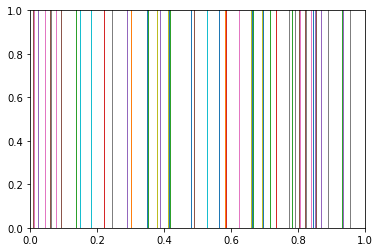

In [288]:
a = ndfpseudonew[ndfpseudonew['label']=='pseudo']['rlon'].values
plt.hist(a)

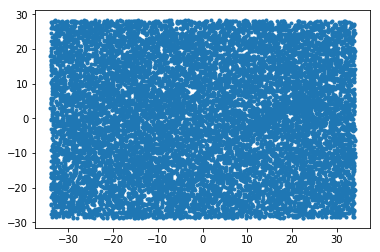

In [232]:
plt.scatter(ndf_full_arr[:, 0], ndf_full_arr[:, 1], marker='.')